In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 60.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: requests
    Found existing installation: requests 2.32.5
    Uninstalling requests-2.32.5:
      Successfully uninstalled requests-2.32.5
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: matplotlib-inline
    Found existing installation: matplotlib-inline 0.1.7
    Uninstalling matplotlib-inline-0.1.7:
      Successfully uninstalled matplot

In [2]:
import collections
import math
import os
import random
import torch
from d2l import torch as d2l

# 下载并读取PTB数据集
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', 
                       '319d85e7e70cdc590547f26231e4e31cdf1e42')

def read_ptb():
    """将PTB数据集加载到文本行列表中"""
    data_dir = d2l.download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
vocab = d2l.Vocab(sentences, min_freq=10)

In [3]:
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元 '<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留“token”，则返回True
    def keep(token):
        return (random.uniform(0, 1) <
                math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([ [token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

# 将词元映射到索引
corpus = [vocab[line] for line in subsampled]

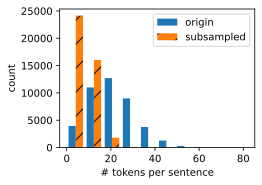

In [4]:
# 展示下采样前后句子长度的直方图对比
# 注意：这需要 d2l 库的支持，或者你需要自己实现绘图逻辑
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence',
                            'count', sentences, subsampled);

In [5]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([l.count(token) for l in sentences])}, '
            f'after={sum([l.count(token) for l in subsampled])}')

print(compare_counts('the'))   # 查看高频词 "the" 的变化
print(compare_counts('join'))  # 查看低频词 "join" 的变化

# 将下采样后的词元映射为索引（构建语料库）
corpus = [vocab[line] for line in subsampled]
print(corpus[:3]) # 打印前3个句子对应的索引列表

# of "the": before=50770, after=2066
# of "join": before=45, after=45
[[], [4127, 3228, 4060], [3895, 993, 3922, 1922, 4743, 2696]]


In [6]:
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳字模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 形成“中心词--上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口以 i 为中心
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [7]:
# 创建一个只有两个句子的微型数据集进行测试
# 句子1长度为7，句子2长度为3
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)

# 打印所有的中心词及其对应的上下文词
# 这里的 2 是最大窗口大小 (max_window_size)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [8]:
class RandomGenerator:
    """根据n个采样权重在 {1, ..., n} 中随机抽取"""
    def __init__(self, sampling_weights):
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [9]:
# 测试随机生成器
# 权重分别为 2, 3, 4，对应的索引是 1, 2, 3
# 理论上索引 3 出现的概率最高
generator = RandomGenerator([2, 3, 4])

# 随机抽取 10 次
print([generator.draw() for _ in range(10)])

[3, 3, 2, 2, 2, 3, 3, 3, 2, 1]


In [10]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self):
        super().__init__()

    # 这里的参数可以有额外的，例如：排除填充后的长度
    def forward(self, X, *args):
        raise NotImplementedError

In [11]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self):
        super().__init__()

    # 用于初始化编码器的状态
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [12]:
class EncoderDecoder(d2l.Classifier):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # 返回解码器输出
        return self.decoder(dec_X, dec_state)[0]